# Erdio: Testing Classifiers

Testing audio classifiers for Project Erdio, an urban environmental sound classifier.

Team members (no particular order): Matthew Frick, Matthew Heffernan, Paul Jredini, Jonathan Osborne, Joanne Dong  

Goal: Classify sounds for key stakeholders (see Stakeholder and KPI documentation).

In those notebook, I'll explore a variety of different classifiers, including Ensemble Learning, in the quest for an optimal classifier. I also investigate the power set to ensure we aren't throwing data at a wall and confusing ourselves.

In [27]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Standard sklearn processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearn Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

## The VotingClassifier
from sklearn.ensemble import VotingClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score, confusion_matrix

# Define shortcuts for classifiers
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA"
]

# Collect classifiers into an iterable
## All the hyperparameters below can and should be investigated
classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=50),
    MLPClassifier(alpha=0.1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
]

## Setting up: Loading data, setting keys

In [28]:
# Keys for classifier 
classify_keys = ['crestfactor','harmonic_power','percussive_power','percussive_hits','harmonic_hits']

In [29]:
# Load data
features_df = pd.read_csv('large_data/eq_with_harmony2.csv')
keys = list(features_df.keys())

In [30]:
use_all = True # Use all features to predict
if use_all:
    classify_keys = keys[1:]

In [31]:
features_df.describe()

,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
count,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,8733.000000,...,8732.000000,8731.000000,8731.000000,8731.000000,8.731000e+03,8.731000e+03,8.731000e+03,8731.000000,8731.000000,8717.000000
mean,41.582894,45.528136,50.671575,53.053241,59.575659,63.065522,63.069491,63.513911,63.055441,60.598247,...,10.648204,8.273487,6.637407,8.104924,1.345436e+00,2.361211e-03,1.782085e-02,8.785592,7.766693,5.379718
std,168.315998,133.477003,123.375278,114.633557,106.321095,98.563501,88.117429,86.430265,83.789542,78.167621,...,13.319128,10.476468,7.535532,5.138068,4.788978e-01,1.339164e-02,5.470170e-01,6.559365,14.160719,2.845315
min,0.000432,0.000540,0.000594,0.000631,0.001056,0.001074,0.001088,0.001651,0.002765,0.000006,...,0.020673,0.016762,0.014721,1.182664,2.899239e-09,6.659914e-14,3.317685e-10,0.000000,0.000000,1.000000
25%,1.734215,2.258343,2.925646,3.630892,5.191355,6.716809,8.190000,9.203399,10.210169,10.770825,...,2.782266,2.128474,1.794573,5.116003,1.000000e+00,4.269569e-06,6.014070e-07,4.000000,1.000000,3.000000
50%,6.872817,8.865405,11.271332,13.303430,20.062739,24.863349,29.544268,31.255598,34.312379,33.756631,...,6.370027,4.889658,4.191099,6.815744,1.000000e+00,2.684106e-05,1.463783e-06,8.000000,3.000000,5.000000
75%,26.263678,34.376928,41.402937,47.154911,62.806814,75.583586,80.458405,81.634991,80.529900,79.438155,...,13.461147,10.353631,8.919814,9.665358,2.000000e+00,2.991143e-04,1.193293e-05,13.000000,7.000000,8.000000
max,3546.550091,2167.821913,1556.984098,1364.750299,1192.576708,1011.511983,963.127206,1032.481591,887.508786,847.766325,...,116.073719,96.531130,87.146006,99.133108,2.000000e+00,6.049485e-01,3.100000e+01,79.000000,86.000000,10.000000


Now that we've loaded the data, I'll drop a fold as recommended by the documentation.

In [40]:
dropfold = 1

cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

In [33]:
cv_features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
0,dog_bark,0.042073,0.037768,0.037040,0.040564,0.103124,0.126494,0.166781,0.199152,0.419491,...,7.060339,5.324175,4.841554,7.006769,1.0,0.000005,2.825963e-03,5.0,1.0,5.0
1,children_playing,7.185887,6.910740,7.921071,7.460572,7.698635,7.091304,6.637689,5.694018,4.534828,...,0.556369,0.417778,0.379089,11.940308,1.0,0.000006,2.081879e-05,11.0,0.0,5.0
2,children_playing,6.597605,6.398027,6.016003,6.052477,5.801635,5.684627,5.734884,4.941867,4.015981,...,0.319594,0.240222,0.218051,8.454538,1.0,0.000016,3.140698e-07,6.0,2.0,5.0
3,children_playing,5.929216,5.157348,5.165380,5.563031,5.046141,5.564920,5.776320,6.222735,5.007891,...,0.808725,0.608560,0.552146,9.255638,1.0,0.000011,8.845374e-05,11.0,4.0,5.0
4,children_playing,8.538324,6.440980,6.393698,7.740646,7.195990,7.131680,6.614982,5.932448,4.940455,...,0.450104,0.338348,0.307133,6.102388,1.0,0.000028,5.712090e-07,16.0,0.0,5.0


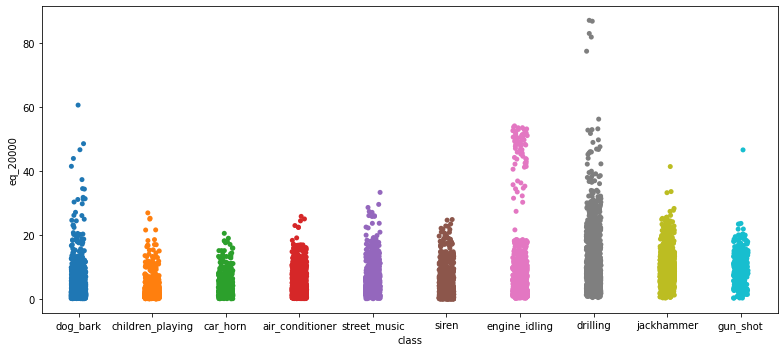

In [46]:
plt.figure(figsize=(11,5))
sns.stripplot(data = cv_features_df,
             x = 'class',
             y = 'eq_20000')
plt.tight_layout()
plt.show()

## Establishing a baseline: The Random Forest

In [35]:
forest = RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=4) 

In [47]:
if len(classify_keys) == 1:
    X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df[classify_keys].values
    
y_train = cv_features_df['class'].values

X_test = validation_features_df[classify_keys].values
y_test = validation_features_df['class']

In [51]:
set(np.where(np.isnan(X_train) == 1)[0])

{351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366}

In [49]:
forest.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [121]:
pred = forest.predict(validation_features_df[classify_keys].values)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [122]:
accuracy_score(pred,validation_features_df['class'])

0.4833906071019473

In [123]:
forest.feature_importances_

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Trying another model: A simple NN

In [124]:
mlp = MLPClassifier(alpha=0.001, max_iter=1000)

In [125]:
mlp.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
pred_mlp = mlp.predict(validation_features_df[classify_keys].values)

In [ ]:
accuracy_score(pred_mlp,validation_features_df['class'])

## Looping through specified models

In [126]:
for i, classifier in enumerate(classifiers):

    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(f'{names[i]} Classifier accuracy score: {accuracy_score(pred,y_test)}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Trying out a Voting Classifier to beat the others

In [127]:
voter_list = [(names[i], classifiers[i]) for i in range(len(names))]

In [103]:
voting = VotingClassifier(voter_list,
                         voting='hard')

In [104]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=10)),
                             ('Linear SVM', SVC(C=0.025, kernel='linear')),
                             ('RBF SVM', SVC(C=1, gamma=2)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=15)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=50)),
                             ('Neural Net',
                              MLPClassifier(alpha=0.1, max_iter=1000)),
                             ('AdaBoost', AdaBoostClassifier()),
                             ('Naive Bayes', GaussianNB()),
                             ('QDA', QuadraticDiscriminantAnalysis())])

In [105]:
vpred = voting.predict(X_test)


In [106]:
accuracy_score(vpred,y_test)

0.54524627720504